### Implementing one-vs-all and softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a one-vs-all logistic regression and softmax regression, and apply it to a version of the CIFAR-10 object recognition dataset. You will write train and predict methods for one-vs-all classification. You will also implement naive, and then more efficient vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

### Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **data\_utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (10000L, 3072L)
Training data shape with bias term:  (49000L, 3073L)
Validation data shape with bias term:  (1000L, 3073L)
Test data shape with bias term:  (10000L, 3073L)


### Implementing a one_vs_all classifier for CIFAR-10
In this part of the exercise, you will implement one-vs-all classifier by training multiple regularized binary logistic regression classifiers, one for each of the ten classes in our dataset. You should now complete the code in **one\_vs\_all.py** to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \Re^{(d+1) \times K}$,  where each column of $\Theta$ corresponds to the learned logistic regression parameters for a class. You can do this with a for-loop from $0$ to $K − 1$, training each classifier independently.
When training the classifier for class $k \in \{0, . . . , K − 1\}$, you should build a new label for each example $x$ as follows: label $x$ as 1 if $x$ belomgs to class $k$ and zero otherwise. You can use sklearn's logistic regression function to learn each classifier. 

Now complete the predict method in **one\_vs\_all.py** to predict on new examples. Once you are done with **train** and **predict** on **one\_vs\_all.py**, run the cell below.


In [3]:
from one_vs_all import one_vs_allLogisticRegressor

ova_logreg = one_vs_allLogisticRegressor(np.arange(10))

# train 
reg = 1.0
ova_logreg.train(X_train,y_train,reg)

# predict on test set
y_test_pred = ova_logreg.predict(X_test)

from sklearn.metrics import confusion_matrix
test_accuracy = np.mean(y_test == y_test_pred)
print 'one_vs_all on raw pixels final test set accuracy: %f' % (test_accuracy, )
print confusion_matrix(y_test,y_test_pred)


one_vs_all on raw pixels final test set accuracy: 0.361400
[[464  58  22  24  19  35  26  60 202  90]
 [ 69 464  18  35  23  31  44  51  91 174]
 [121  64 193  77  96  89 151  89  73  47]
 [ 66  86  78 161  48 193 171  51  63  83]
 [ 65  38 103  64 234  90 194 129  35  48]
 [ 49  64  81 127  81 273 114  89  67  55]
 [ 31  53  67 102  87  78 456  51  29  46]
 [ 53  62  50  46  68  85  66 406  48 116]
 [146  79   8  25   9  34  22  19 543 115]
 [ 59 208  14  22  23  29  59  56 110 420]]


### Visualizing the learned one-vs-all classifier

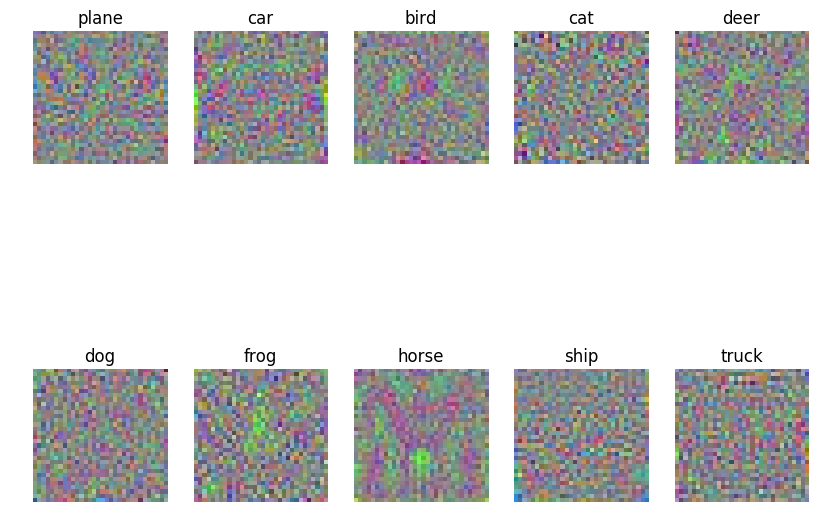

In [4]:
# Visualize the learned weights for each class

theta = ova_logreg.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()

### Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=1}^{K}\sum_{k=1}^{K} {\theta_{jk}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [5]:
from softmax1 import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)
#loss, grad = softmax_loss_vectorized(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.38

print 'loss: (should be close to 2.38): ', loss

loss: (should be close to 2.38):  2.39962466969


### Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [6]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
#f = lambda th: softmax_loss_vectorized(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
#loss_naive, grad_naive = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

numerical: -2.567933 analytic: -2.567933, relative error: 2.393043e-11
numerical: -0.938644 analytic: -0.938645, relative error: 2.984405e-08
numerical: 2.085903 analytic: 2.085903, relative error: 1.420317e-08
numerical: 1.479042 analytic: 1.479042, relative error: 1.788271e-08
numerical: 0.522346 analytic: 0.522346, relative error: 2.331575e-08
numerical: 0.591754 analytic: 0.591754, relative error: 1.222384e-07
numerical: -0.107814 analytic: -0.107814, relative error: 1.048036e-07
numerical: 1.242172 analytic: 1.242172, relative error: 3.563506e-08
numerical: -2.584456 analytic: -2.584456, relative error: 6.985673e-09
numerical: 0.807895 analytic: 0.807895, relative error: 5.611525e-08
naive loss: 2.399625e+00 computed in 37.682000s


### Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax1 import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

vectorized loss: 2.399625e+00 computed in 5.024000s
Loss difference: 0.000000
Gradient difference: 0.000000


### Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

### Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = linear_classifier.Softmax()
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################

best_lamda=learning_rates[0]
best_reg=regularization_strengths[0]
from linear_classifier import LinearClassifier
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        lin=LinearClassifier()
        lin.train(X_train,y_train,learning_rates[i],regularization_strengths[j],2000,200,verbose=False)
        y_train_pred = lin.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = lin.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)

        results[(learning_rates[i], regularization_strengths[j])] = (accuracy_train, accuracy_val)
        
        if (accuracy_val>best_val):
            best_val=accuracy_val
            best_softmax=lin
            best_lamda=learning_rates[i]
            best_reg=regularization_strengths[j]
#        if (np.mean(y_train==lin.predict(X_train))>best_train):
#            best_train=np.mean(y_train==lin.predict(X_train))
#            best_softmax=lin
#        if (np.mean(y_val==lin.predict(X_val))>best_val):
#            best_val=np.mean(y_val==lin.predict(X_val))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.261102 val accuracy: 0.274000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.261776 val accuracy: 0.262000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.291327 val accuracy: 0.270000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.268510 val accuracy: 0.280000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.344531 val accuracy: 0.362000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.358857 val accuracy: 0.347000
lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.397429 val accuracy: 0.390000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.261163 val accuracy: 0.257000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.383673 val accuracy: 0.390000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.404980 val accuracy: 0.399000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.396531 val accuracy: 0.403000
lr 1.000000e-06 reg 1.000000e+08 train accuracy: 0.279510 val accuracy: 0.288000
lr 5.000000e-06 reg 5.000000

### Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

softmax on raw pixels final test set accuracy: 0.390800
[[523  57  50  17  12  19  36  29 174  83]
 [ 79 488  13  24  20  48  62  31  74 161]
 [121  49 212  62 100  88 227  54  53  34]
 [ 60  76  73 181  47 206 191  44  51  71]
 [ 71  34  91  37 258  95 263  88  30  33]
 [ 54  45  87 113  58 345 136  70  64  28]
 [ 24  55  55  74  66  79 554  24  20  49]
 [ 68  44  56  42 102  79  80 369  47 113]
 [178  97   6  12   9  56  10  17 486 129]
 [ 84 194   7  25  11  21  50  32  84 492]]


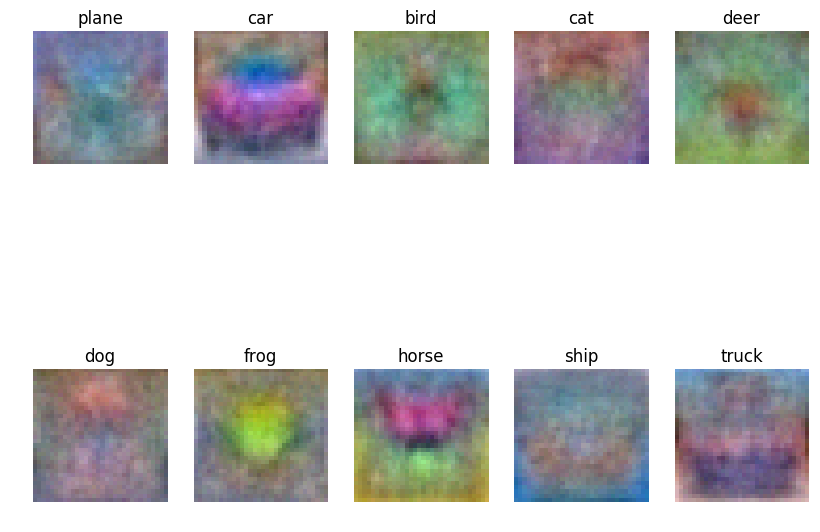

In [17]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test,y_test_pred)

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()

### Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? Answer these questions with supporting plots in **writeup.pdf**

### Comparing one-vs-all logistic regression and softmax regression on CIFAR-10
Compare the performance results from your OVA and softmax regression classifier. Provide a table with classification performance of each classifier on each CIFAR-10 category. Explain performance differences, if any, or explain why their performance is similar, if it is. Which approach would you recommend for the CIFAR-10 classification problem? Place answers to these questions in **writeup.pdf**.